In [4]:
# check if IS_MASTER exists, this variable will only exist if it's being called by MASTER notebook.
# if it does not exist, set it to False
try: IS_MASTER
except: IS_MASTER = False
# The code below will only run if it's NOT being called from MASTER notebook
if not IS_MASTER:
    DATA_DIR = './data/temp/'
    EXP_DIR = './exp/temp/'
    PROCESSED_FILE = f'{DATA_DIR}processed.pkl'
    MODEL_FILE = f'{EXP_DIR}model.pkl'
    PREDICTION_FILE = f'{EXP_DIR}ypred.pkl'
    OTHER_MODEL_PARAMETERS = ... # like N_ESTIMATOR, GAMMA, etc

In [5]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
%run plot_learning_curve
import pickle


ERROR:root:File `'plot_learning_curve.py'` not found.


In [6]:
df = pd.read_pickle(PROCESSED_FILE)
df.head()

,id,text,full_text,text2Proc,target
14286,1.194698e+18,Cómo consumir un buen vermut (Olvídate del hie...,NaN,Cómo consumir un buen vermut (Olvídate del hie...,0
8480,1.194663e+18,Lo cierto que si Albert Rivera era la veleta n...,Lo cierto que si Albert Rivera era la veleta n...,Lo cierto que si Albert Rivera era la veleta n...,0
4515,1.194641e+18,Cuando mi madre me pone lentejas,NaN,Cuando mi madre me pone lentejas,0
233,1.194612e+18,@Soumastre Jajajjaa palabras de un chico reali...,NaN,@Soumastre Jajajjaa palabras de un chico reali...,0
10952,1.194677e+18,Mango se viste de etiqueta para dar la bienven...,NaN,Mango se viste de etiqueta para dar la bienven...,0


In [11]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 770 entries, 1865 to 499
Data columns (total 3 columns):
id           770 non-null float64
text2Proc    770 non-null object
target       770 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 24.1+ KB


Classifiers must work with numbers type so we have to transform object types into int64 types.

Classification
==============
 Finally, we are going to create a model able to decide if a tweet talks about an incident It's important to have in mind that the entry of our classifier is a set of documents (or tweets), so to use text characteristics and the other columns from the DataFrame it's necesary to implement a series of tranformers to include the features

In [12]:
# Define X and Y
X = df['text2Proc'].values
y = df['target'].values

Lexical Features
=================

In [13]:
# Sample of statistics using nltk
# Another option is defining a function and pass it as a parameter to FunctionTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import sent_tokenize, word_tokenize

class LexicalStats (BaseEstimator, TransformerMixin):
    """Extract lexical features from each document"""
    
    def number_sentences(self, doc):
        sentences = sent_tokenize(doc, language='spanish')
        return len(sentences)

    def fit(self, x, y=None):
        return self

    def transform(self, docs):
        return [{'length': len(doc),
                 'num_sentences': self.number_sentences(doc)}
                for doc in docs]


In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re
import string

def custom_tokenizer(words):
    """Preprocessing tokens as seen in the lexical notebook"""

    urls = re.compile(r'.http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    ht = re.compile(r'http.')
    bar = re.compile(r'//*')
    pr = ["rt","@","http","https","'s",'...', 'english', 'translation','):', '. .', '..']
    #tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
    tknzr = TweetTokenizer(strip_handles=False, reduce_len=True)
    #tokens = word_tokenize(words.lower())
    tokens = tknzr.tokenize(words.lower())
    porter = PorterStemmer()
    lemmas = [porter.stem(t) for t in tokens]
    # Clean stop-words
    stoplist = stopwords.words('spanish')
    lemmas_clean = [w for w in lemmas if w not in stoplist]
    # Clean punctuation
    punctuation = set(string.punctuation)
    lemmas_punct = [w for w in lemmas_clean if  w not in punctuation]
    # Clean emojis,urls,bars,etc
    lemmas_clean = [w for w in lemmas_punct if not w.startswith('@') if w not in pr 
            if not bar.search(w) if not ht.search(w)
            if not w.isdigit()]
    
    return lemmas_clean

Feature Extraction Pipelines
====================

In [15]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer


ngrams_featurizer = Pipeline([
  ('count_vectorizer',  CountVectorizer(ngram_range = (1, 3), encoding = 'utf-8', 
                                        tokenizer=custom_tokenizer)),
  ('tfidf_transformer', TfidfTransformer())
])

Feature Union Pipeline
======

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def pipeline(clf):
    return Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    # Topics of the Docs
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_components=2, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
        # Machine Learning
        ('clf', clf)  # classifier
        #('clf', SVC(gamma= 3, kernel='linear', probability=True))

    ])

def classification_report_with_accuracy_score(y_true, y_pred):

    print (classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

cv = KFold(n_splits=5, shuffle=True, random_state=33)

Train, Optimize and Evaluate models
======

Extra Trees
------

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

#Optimize RandomForests
pipelineRF = pipeline(ExtraTreesClassifier(n_estimators=1000))

parametersRF = {'clf__n_estimators': range (1,43)}

gs_RF = GridSearchCV(pipelineRF, parametersRF)

In [21]:
gs_RF= gs_RF.fit(X,y) 

In [27]:
print("Best Score with Extra Trees: %s" % gs_RF.best_score_)
for param_name in sorted(parametersRF.keys()):
    print("%s: %r" % (param_name, gs_RF.best_params_[param_name]))

Best Score with RandomForests: 0.868831168831
clf__n_estimators: 33


In [23]:
#Evaluate with K-Fold
model_ET = pipeline(ExtraTreesClassifier(n_estimators=gs_RF.best_params_['clf__n_estimators'],n_jobs=-1))
scores = cross_val_score(model_ET, X, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [ 0.83766234  0.87662338  0.85064935  0.84415584  0.94155844]
Accuracy: 0.87 (+/- 0.08)


In [28]:
type(model_ET)

sklearn.pipeline.Pipeline

In [34]:
from joblib import dump, load
dump(model_ET, 'exp/models/model_ET.joblib')

['Models/model_RF-d02.joblib']

In [35]:
clf = load('exp/models/model_ET.joblib') 
scores = cross_val_score(clf, X, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(clf, X, y, cv=cv, scoring='precision')
print("Scores in every iteration", scores)
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(clf, X, y, cv=cv, scoring='recall')
print("Scores in every iteration", scores)
print("Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(clf, X, y, cv=cv, scoring='f1')
print("Scores in every iteration", scores)
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [ 0.83766234  0.88961039  0.85064935  0.80519481  0.90909091]
Accuracy: 0.86 (+/- 0.07)
Scores in every iteration [ 0.92424242  0.95890411  0.89393939  0.95        0.87878788]
Precision: 0.92 (+/- 0.06)
Scores in every iteration [ 0.77777778  0.85365854  0.75        0.73809524  0.91935484]
Recall: 0.81 (+/- 0.14)
Scores in every iteration [ 0.76595745  0.87581699  0.82269504  0.8         0.92682927]
F1: 0.84 (+/- 0.11)


In [42]:
df_random = df.sample(frac=1)
r_features = df_random.text2Proc.values[:100]
r_target = df_random.target.values[:100]

In [43]:
predicted = clf.predict(r_features)
expected = r_target

In [44]:
predicted

array([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1])

In [45]:
expected

array([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1])

In [61]:
clf.predict(['me apetece un par de birras'])

array([0])

In [47]:
from sklearn import metrics

metrics.accuracy_score(expected, predicted) 

1.0

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

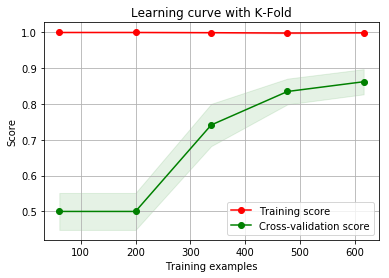

In [24]:
plot_learning_curve(model_ET, "Learning curve with K-Fold", X, y, cv=cv) 

In [25]:
# Nested CV with parameter optimization
nested_score = cross_val_score(model_RF, X, y, cv=cv, \
               scoring=make_scorer(classification_report_with_accuracy_score))
print (nested_score) 

              precision    recall  f1-score   support

           0       0.78      0.89      0.83        73
           1       0.89      0.78      0.83        81

    accuracy                           0.83       154
   macro avg       0.84      0.83      0.83       154
weighted avg       0.84      0.83      0.83       154

              precision    recall  f1-score   support

           0       0.83      0.94      0.88        72
           1       0.94      0.83      0.88        82

    accuracy                           0.88       154
   macro avg       0.89      0.89      0.88       154
weighted avg       0.89      0.88      0.88       154

              precision    recall  f1-score   support

           0       0.79      0.94      0.86        78
           1       0.92      0.75      0.83        76

    accuracy                           0.84       154
   macro avg       0.86      0.84      0.84       154
weighted avg       0.86      0.84      0.84       154

              preci

In [26]:
#Train classifier
model_RF.fit(X,y)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('lexical_stats',
                                                 Pipeline(memory=None,
                                                          steps=[('stats',
                                                                  LexicalStats()),
                                                                 ('vectors',
                                                                  DictVectorizer(dtype=<class 'numpy.float64'>,
                                                                                 separator='=',
                                                                                 sort=True,
                                                                                 sparse=True))],
                                                          verbose=False)),
                                                ('words',
    